In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pywave.energy_transport.lib import solve_2d_ode_spectral
from pywave.energy_transport.energy_transfer_2dirns import EnergyTransfer2Dirns

In [2]:
class ET2dirnsManager(EnergyTransfer2Dirns):
    def __init__(self, dx, dt, cg,
                 neumann=True,
                 u_in=1,
                 reflection_coefficient=1,
                 alpha=.1,
                 gamma=0,
                 nx=100,
                 nt=50,
                 outdir=None,
                 **kwargs):
        super().__init__(dx, dt, **kwargs)
        self.nx = int(nx)
        self.nt = int(nt)
        self.x = np.arange(nx, dtype=float)*dx
        self.neumann = neumann
        self.u_in = u_in
        self.outdir = outdir
        self.set_init_cons()
        self.set_scattering_props(alpha, gamma, cg)
        self.set_steady_cons(alpha, gamma, reflection_coefficient)

    def set_init_cons(self):
        self.u0 = np.full_like(self.x, self.u_in)
        self.u0[self.x>self.x[self.nx//3]] = 0
        self.v0 = np.zeros_like(self.x)
        self.u = self.u0.copy()
        self.v = self.v0.copy()

    def set_scattering_props(self, alpha, gamma, cg):
        self.scattering_mask = np.zeros_like(self.x)
        self.scattering_mask[self.x>self.x[self.nx//2]] = 1.
        self.alpha = alpha*self.scattering_mask
        self.gamma = gamma*self.scattering_mask
        self.cg = np.full_like(self.x, cg)
         
    def set_steady_cons(self, alpha, gamma, reflection_coefficient):
        a, b, c, d = self.get_source_matrix(alpha, gamma, shape=(1,))
        dcg = np.gradient(self.cg)/self.dx
        abcd = [arr/self.cg[0] for arr in (a - dcg[0], b, -c, dcg[0] - d)]
        u0 = np.array([self.u_in])
        v0 = reflection_coefficient*u0
        self.u_steady = np.full_like(self.x, u0[0])
        self.v_steady = np.full_like(self.x, v0[0])
        wh = np.where(self.scattering_mask==1.)
        x = self.x[wh]
        self.u_steady[wh], self.v_steady[wh] = (
            arr.flatten() for arr in solve_2d_ode_spectral(u0, v0, x-x[0], *abcd))

    def plot_step(self, n):
        plt.close()
        fig, axes = plt.subplots(
            nrows=3, ncols=1, sharex=True, squeeze=True)
        for ax, arr, arr_steady, ylabel in zip(
                axes,
                [self.u, self.v, self.u + self.v],
                [self.u_steady, self.v_steady, self.u_steady + self.v_steady],
                ["$E_+$", "$E_-$", "E_+ + E_-"],
                ):
            ax.plot(self.x, arr_steady, 'r')
            ax.plot(self.x, arr, '--')
            ax.set_ylabel(ylabel)
            ax.set_yscale('log')
            ax.set_ylim([1e-4, 3])
            ttl = "t=%5.3f" %(n*self.dt)
        axes[0].set_title(ttl)
        axes[-1].set_xlabel("x, m")
        if self.outdir is None: return
        os.makedirs(self.outdir, exist_ok=True)
        figname = os.path.join(self.outdir, 'et2d_%3.3i.png' %n)
        plt.savefig(figname)
        
    def step_with_bcs(self):
        nghost = 3
        n = self.nx + 2*nghost
        s = slice(nghost, -nghost)
        def pad(vec, val, dtype=float):
            padded = np.full((n,), val)
            padded[s] = vec[:]
            return padded
        upad = pad(self.u, self.u_in)
#         print(self.u)
#         print(upad)
        vpad = pad(self.v, 0.)
        cgpad = pad(self.cg, self.cg[0])
        apad = pad(self.alpha, 0.)
        gpad = pad(self.gamma, 0.)
        upad, vpad = self.step(upad, vpad, cgpad, apad, gpad)
#         print(upad)
#         print(vpad[-15:])
        self.u = upad[s]
        self.v = vpad[s]

    def step_simple(self):
        self.u, self.v = self.step(
            self.u, self.v, self.cg, self.alpha, self.gamma,
            neumann=self.neumann, u_in=self.u_in)

    def run(self, reps=10):
        if self.outdir is not None:
            print(f"Saving figs in {self.outdir}")
        for n in range(1, self.nt+1):
#             self.step_with_bcs()
            self.step_simple()
            if n%reps != 0: continue
            print(f"Plotting step {n} out of {self.nt}")
            self.plot_step(n)

In [3]:
cfl = .9
dx = 1
dt = 1
alpha = 5e-2
gamma = 0
cg = cfl*dx/dt
refl = 1

# Anisotropic scattering

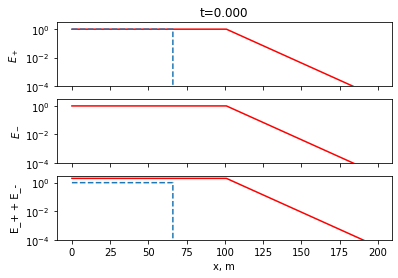

In [4]:
# no dissipation
# - implicit solver with smaller time step
et2d = ET2dirnsManager(
    dx, dt/10, cg,
    reflection_coefficient=refl,
    alpha=alpha,
    gamma=gamma,
    nx=200,
    nt=10e3,
    outdir="figs_aniso_implicit",
    aniso=True,
    scheme="lax_wendroff",
    limiter="superbee",
    u_correction_scheme="implicit",
    neumann=False,
    u_in=1,
)
et2d.plot_step(0)

In [5]:
# check steady solution
print(
    et2d.u_steady[101:121], 
    np.exp((-2*alpha/cg)*np.arange(20)*dx),
    sep='\n'
)

[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]
[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]


Saving figs in figs_aniso_implicit
Plotting step 50 out of 10000
Plotting step 100 out of 10000
Plotting step 150 out of 10000
Plotting step 200 out of 10000
Plotting step 250 out of 10000
Plotting step 300 out of 10000
Plotting step 350 out of 10000
Plotting step 400 out of 10000
Plotting step 450 out of 10000
Plotting step 500 out of 10000
Plotting step 550 out of 10000
Plotting step 600 out of 10000
Plotting step 650 out of 10000
Plotting step 700 out of 10000
Plotting step 750 out of 10000
Plotting step 800 out of 10000
Plotting step 850 out of 10000
Plotting step 900 out of 10000
Plotting step 950 out of 10000
Plotting step 1000 out of 10000
Plotting step 1050 out of 10000
Plotting step 1100 out of 10000
Plotting step 1150 out of 10000
Plotting step 1200 out of 10000
Plotting step 1250 out of 10000
Plotting step 1300 out of 10000
Plotting step 1350 out of 10000
Plotting step 1400 out of 10000
Plotting step 1450 out of 10000
Plotting step 1500 out of 10000
Plotting step 1550 out of

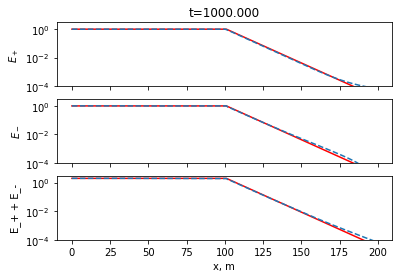

In [6]:
et2d.run(reps=50)

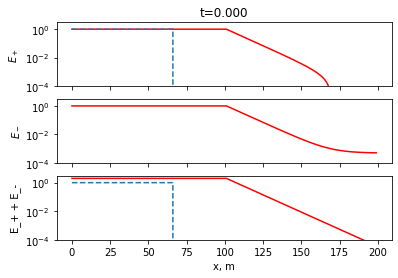

In [7]:
# no dissipation
# - split-step solver with larger time step
# - final results not very sensible
et2d = ET2dirnsManager(
    dx, dt, cg,
    reflection_coefficient=refl,
    alpha=alpha,
    gamma=gamma + alpha*1e-3,
    nx=200,
    nt=10e3,
    outdir="figs_aniso_split",
    aniso=True,
    scheme="lax_wendroff",
    limiter="superbee",
    u_correction_scheme="split_step",
    neumann=False,
    u_in=1,
    )
et2d.plot_step(0)
# et2d.run(reps=50)